# 4x4 Puzzle Solver Batch Test (v2)

This notebook uses **Pairwise Neighbor Accuracy** with proper ground-truth labeling.

- Piece IDs are arbitrary (no semantic meaning)
- Ground truth is derived by matching shuffled pieces to the correct image
- Accuracy measures relative adjacency, not absolute position

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, Tuple, List
from solvers.solver_4x4 import solve_4x4
from pipeline.artifact_pipeline import create_artifact

%matplotlib inline

## Core Functions

In [20]:
def compute_pairwise_neighbor_accuracy(
    reconstructed_grid: np.ndarray,
    ground_truth_labels: Dict[int, Tuple[int, int]]
) -> float:
    """
    Compute Pairwise Neighbor Accuracy for a reconstructed puzzle grid.
    
    This metric measures how many adjacent pairs in the reconstruction are
    actually neighbors in the ground truth, regardless of absolute position.
    
    Args:
        reconstructed_grid: 2D numpy array of piece IDs, with -1 for empty cells.
        ground_truth_labels: Dict mapping piece_id -> (row, col) in the solved puzzle.
    
    Returns:
        Score in [0.0, 1.0] representing the fraction of correct neighbor pairs.
    """
    rows, cols = reconstructed_grid.shape
    
    # Build ground-truth neighbor sets from labels
    pos_to_piece = {pos: pid for pid, pos in ground_truth_labels.items()}
    
    gt_right_neighbors = {}
    gt_bottom_neighbors = {}
    
    for piece_id, (r, c) in ground_truth_labels.items():
        gt_right_neighbors[piece_id] = pos_to_piece.get((r, c + 1))
        gt_bottom_neighbors[piece_id] = pos_to_piece.get((r + 1, c))
    
    correct_pairs = 0
    total_pairs = 0
    
    # Check horizontal pairs
    for r in range(rows):
        for c in range(cols - 1):
            left_piece = reconstructed_grid[r, c]
            right_piece = reconstructed_grid[r, c + 1]
            
            if left_piece == -1 or right_piece == -1:
                continue
            
            total_pairs += 1
            if gt_right_neighbors.get(left_piece) == right_piece:
                correct_pairs += 1
    
    # Check vertical pairs
    for r in range(rows - 1):
        for c in range(cols):
            top_piece = reconstructed_grid[r, c]
            bottom_piece = reconstructed_grid[r + 1, c]
            
            if top_piece == -1 or bottom_piece == -1:
                continue
            
            total_pairs += 1
            if gt_bottom_neighbors.get(top_piece) == bottom_piece:
                correct_pairs += 1
    
    return correct_pairs / total_pairs if total_pairs > 0 else 0.0

In [21]:
def extract_pieces(image: np.ndarray, grid_size: int) -> List[np.ndarray]:
    """Extract pieces from an image in row-major order."""
    h, w = image.shape[:2]
    piece_h, piece_w = h // grid_size, w // grid_size
    
    pieces = []
    for row in range(grid_size):
        for col in range(grid_size):
            y1, y2 = row * piece_h, (row + 1) * piece_h
            x1, x2 = col * piece_w, (col + 1) * piece_w
            pieces.append(image[y1:y2, x1:x2].copy())
    return pieces


def load_puzzle_with_ground_truth(
    puzzle_path: str,
    correct_path: str,
    grid_size: int = 4
) -> Tuple[dict, Dict[int, Tuple[int, int]]]:
    """
    Load shuffled puzzle pieces and derive ground truth labels by matching
    to the correct (unshuffled) image.
    """
    puzzle_img = cv2.imread(puzzle_path)
    correct_img = cv2.imread(correct_path)
    
    if puzzle_img is None:
        raise ValueError(f"Could not load puzzle image: {puzzle_path}")
    if correct_img is None:
        raise ValueError(f"Could not load correct image: {correct_path}")
    
    puzzle_pieces = extract_pieces(puzzle_img, grid_size)
    correct_pieces = extract_pieces(correct_img, grid_size)
    
    # Build artifacts dict using the artifact pipeline
    artifacts = {}
    for idx, piece in enumerate(puzzle_pieces):
        artifacts[idx] = create_artifact(piece)
    
    # Compute all match scores
    scores = []
    for piece_id, piece in enumerate(puzzle_pieces):
        for pos_idx, correct_piece in enumerate(correct_pieces):
            if correct_piece.shape != piece.shape:
                correct_piece = cv2.resize(correct_piece, (piece.shape[1], piece.shape[0]))
            diff = np.sum((piece.astype(float) - correct_piece.astype(float)) ** 2)
            scores.append((diff, piece_id, pos_idx))
    
    # Greedy assignment
    scores.sort()
    ground_truth_labels = {}
    assigned_pieces = set()
    used_positions = set()
    
    for diff, piece_id, pos_idx in scores:
        if piece_id in assigned_pieces or pos_idx in used_positions:
            continue
        
        row, col = pos_idx // grid_size, pos_idx % grid_size
        ground_truth_labels[piece_id] = (row, col)
        assigned_pieces.add(piece_id)
        used_positions.add(pos_idx)
        
        if len(assigned_pieces) == len(puzzle_pieces):
            break
    
    return artifacts, ground_truth_labels


def arrangement_to_grid(arrangement: List[int], grid_size: int = 4) -> np.ndarray:
    """Convert flat arrangement list to 2D grid array."""
    return np.array(arrangement).reshape(grid_size, grid_size)


def reconstruct_image(artifacts: dict, arrangement: List[int], grid_size: int = 4) -> np.ndarray:
    """Reconstruct the solved puzzle image from arrangement."""
    sample = artifacts[0]['rgb']
    piece_h, piece_w = sample.shape[:2]
    
    output = np.zeros((piece_h * grid_size, piece_w * grid_size, 3), dtype=np.uint8)
    
    idx = 0
    for r in range(grid_size):
        for c in range(grid_size):
            piece_id = arrangement[idx]
            if piece_id != -1:
                y1, y2 = r * piece_h, (r + 1) * piece_h
                x1, x2 = c * piece_w, (c + 1) * piece_w
                output[y1:y2, x1:x2] = artifacts[piece_id]['rgb']
            idx += 1
    
    return output

## Configuration

In [22]:
PUZZLE_DIR = "./Gravity Falls/puzzle_4x4"
CORRECT_DIR = "./Gravity Falls/correct"
NUM_IMAGES = 110
GRID_SIZE = 4

## Run Batch Test

In [23]:
puzzle_path = Path(PUZZLE_DIR)
correct_path = Path(CORRECT_DIR)

puzzle_files = sorted(puzzle_path.glob("*.jpg"), key=lambda p: int(p.stem))[:NUM_IMAGES]
print(f"Found {len(puzzle_files)} puzzle images")

Found 110 puzzle images


In [ ]:
results = []

for i, puzzle_file in enumerate(puzzle_files):
    # Find corresponding correct image
    correct_file = correct_path / f"{puzzle_file.stem}.png"
    if not correct_file.exists():
        correct_file = correct_path / f"{puzzle_file.stem}.jpg"
    
    if not correct_file.exists():
        print(f"[{i+1}] {puzzle_file.name}: SKIP (no correct image)")
        continue
    
    try:
        # Load with ground truth
        artifacts, ground_truth_labels = load_puzzle_with_ground_truth(
            str(puzzle_file), str(correct_file), GRID_SIZE
        )
        
        # Solve (verbose=False to reduce output)
        board, arrangement, solver_score = solve_4x4(artifacts, verbose=False)
        
        # Compute accuracy
        reconstructed_grid = arrangement_to_grid(arrangement, GRID_SIZE)
        accuracy = compute_pairwise_neighbor_accuracy(reconstructed_grid, ground_truth_labels)
        
        status = "✓" if accuracy == 1.0 else f"{accuracy:.0%}"
        print(f"[{i+1}] {puzzle_file.name}: {status}")
        
        results.append({
            'image': puzzle_file.name,
            'arrangement': arrangement,
            'solver_score': solver_score,
            'neighbor_accuracy': accuracy,
            'ground_truth_labels': ground_truth_labels,
            'artifacts': artifacts
        })
        
    except Exception as e:
        print(f"[{i+1}] {puzzle_file.name}: ERROR - {e}")
        import traceback
        traceback.print_exc()
        results.append({
            'image': puzzle_file.name,
            'neighbor_accuracy': 0.0,
            'error': str(e)
        })

    Row 1: 43680 -> 20000 states
    Row 2: 180000 -> 20000 states
    Row 3: 100000 -> 20000 states
    Row 4: 20000 -> 20000 states
    Hillclimb: 0 improvements
[1] 0.jpg: ✓
    Row 1: 43680 -> 20000 states
    Row 2: 180000 -> 20000 states
    Row 3: 100000 -> 20000 states
    Row 4: 20000 -> 20000 states
    Hillclimb: 0 improvements
[2] 1.jpg: ✓
    Row 1: 43680 -> 20000 states
    Row 2: 180000 -> 20000 states
    Row 3: 100000 -> 20000 states
    Row 4: 20000 -> 20000 states
    Hillclimb: 0 improvements
[3] 2.jpg: ✓
    Row 1: 43680 -> 20000 states


## Summary

In [ ]:
valid_results = [r for r in results if 'error' not in r]
accuracies = [r['neighbor_accuracy'] for r in valid_results]

perfect_count = sum(1 for a in accuracies if a == 1.0)
mean_accuracy = np.mean(accuracies) if accuracies else 0.0

print(f"Total tested: {len(valid_results)}")
print(f"Perfect: {perfect_count}/{len(valid_results)} ({100*perfect_count/len(valid_results):.1f}%)")
print(f"Mean pairwise neighbor accuracy: {mean_accuracy:.2%}")

Total tested: 20
Perfect: 20/20 (100.0%)
Mean pairwise neighbor accuracy: 100.00%


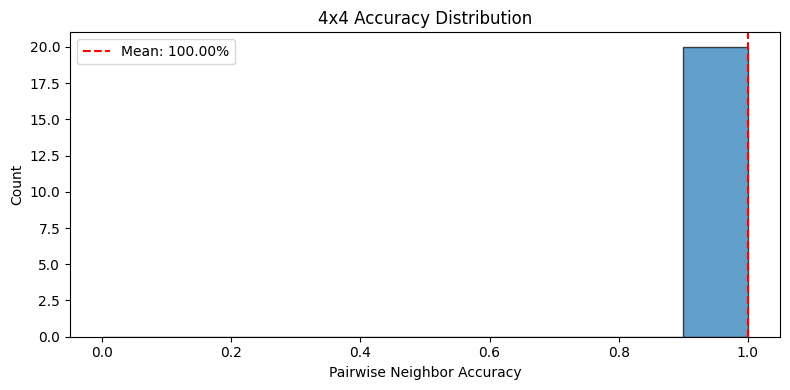

In [ ]:
# Accuracy distribution
plt.figure(figsize=(8, 4))
plt.hist(accuracies, bins=10, range=(0, 1), edgecolor='black', alpha=0.7)
plt.xlabel('Pairwise Neighbor Accuracy')
plt.ylabel('Count')
plt.title('4x4 Accuracy Distribution')
plt.axvline(mean_accuracy, color='red', linestyle='--', label=f'Mean: {mean_accuracy:.2%}')
plt.legend()
plt.tight_layout()
plt.show()

## Visualize Results

In [ ]:
# Show ALL results in a grid
import math

n_total = len(valid_results)
n_cols = 10  # 10 images per row
n_rows = math.ceil(n_total / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes.flatten()

for i, r in enumerate(valid_results):
    # Reconstructed
    solved_img = reconstruct_image(r['artifacts'], r['arrangement'], GRID_SIZE)
    solved_rgb = cv2.cvtColor(solved_img, cv2.COLOR_BGR2RGB)
    
    ax = axes[i]
    ax.imshow(solved_rgb)
    status = "✓" if r['neighbor_accuracy'] == 1.0 else f"{r['neighbor_accuracy']:.0%}"
    color = 'green' if r['neighbor_accuracy'] == 1.0 else 'red'
    ax.set_title(f"{r['image'].replace('.jpg','')}:{status}", fontsize=8, color=color)
    ax.axis('off')

# Hide unused axes
for j in range(n_total, len(axes)):
    axes[j].axis('off')
    axes[j].set_visible(False)

plt.suptitle(f'All 4x4 Results ({perfect_count}/{n_total} perfect)', fontsize=14)
plt.tight_layout()
plt.show()

## Imperfect Solutions

In [ ]:
imperfect = [r for r in valid_results if r['neighbor_accuracy'] < 1.0]

if imperfect:
    print(f"Imperfect solutions: {len(imperfect)}")
    for r in imperfect:
        print(f"  {r['image']}: {r['neighbor_accuracy']:.0%}")
else:
    print("All solutions are perfect!")

All solutions are perfect!


In [ ]:
# Visualize worst cases
if imperfect:
    worst = sorted(imperfect, key=lambda x: x['neighbor_accuracy'])[:3]
    
    fig, axes = plt.subplots(2, len(worst), figsize=(4*len(worst), 8))
    if len(worst) == 1:
        axes = axes.reshape(2, 1)
    
    for i, r in enumerate(worst):
        solved_img = reconstruct_image(r['artifacts'], r['arrangement'], GRID_SIZE)
        solved_rgb = cv2.cvtColor(solved_img, cv2.COLOR_BGR2RGB)
        
        gt_arrangement = [None] * (GRID_SIZE * GRID_SIZE)
        for pid, (row, col) in r['ground_truth_labels'].items():
            gt_arrangement[row * GRID_SIZE + col] = pid
        correct_img = reconstruct_image(r['artifacts'], gt_arrangement, GRID_SIZE)
        correct_rgb = cv2.cvtColor(correct_img, cv2.COLOR_BGR2RGB)
        
        axes[0, i].imshow(solved_rgb)
        axes[0, i].set_title(f"{r['image']}\nSolved ({r['neighbor_accuracy']:.0%})")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(correct_rgb)
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')
    
    plt.suptitle('Worst Cases')
    plt.tight_layout()
    plt.show()